# VarClump2D: Concept test

## _Without optimizations..._

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational2 import *

# ACALIB helper functions
sys.path.append('../../ACALIB/')
import acalib
from acalib import load_fits, standarize

# extra metric module
#import custom_metric as cm

## Loading data 2D: Stacked on frequency

In [2]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'

def load_data(fit_path):
    container = load_fits(fit_path)
    data = standarize(container.primary)[0]
    data = data.data

    # stacking it
    data = data.sum(axis=0)
    data -= data.min()
    data /= data.max()

    # generating the data function
    x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
    _dfunc = RegularGridInterpolator((x,y), data, method='linear', bounds_error=False, fill_value=0.)
    
    def dfunc(points):
        if points.ndim==1:
            return _dfunc([[points[1],points[0]]])
        elif points.ndim==2:
            return  _dfunc(points[:,::-1])
    
    return x, y, data, dfunc

x, y, data, dfunc = load_data(fit_path)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


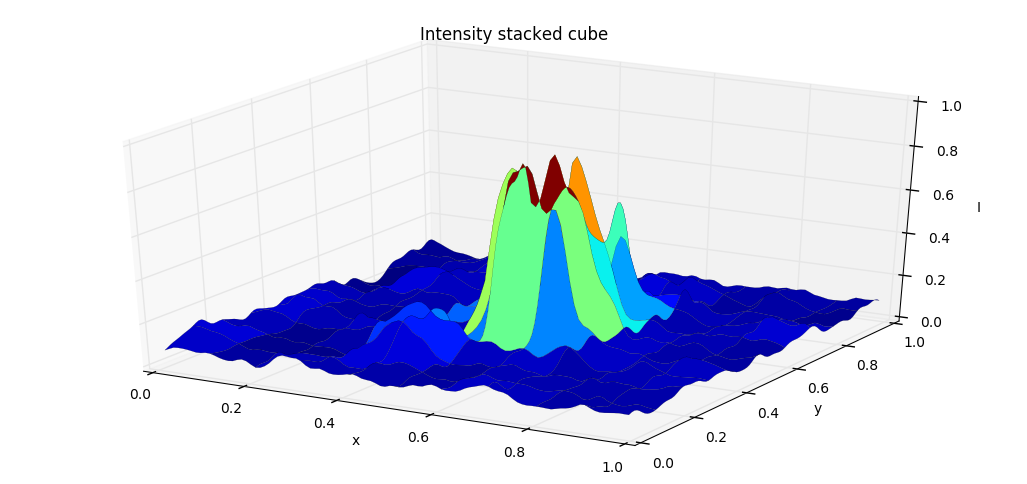

In [3]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

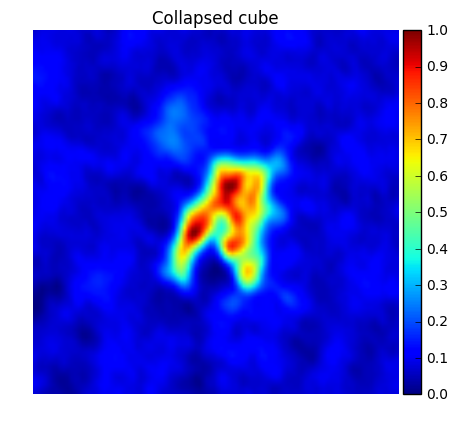

In [4]:
plt.figure(figsize=(5,5))
im = plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^2} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^2}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i,y_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

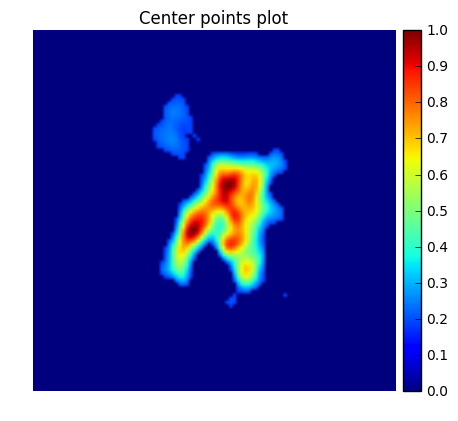

In [5]:
base_level = estimate_rms(data)

plt.figure(figsize=(5,5))
ax = plt.gca()
_data = np.zeros(data.shape)
mask = data > base_level
_data[mask] = data[mask]
im = ax.imshow(_data)
plt.title('Center points plot')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)
plt.show()

#### Visualizing the level sets

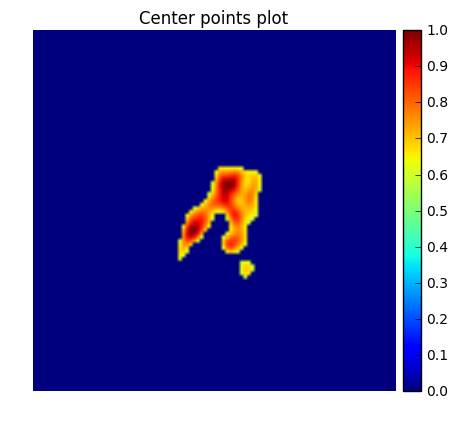

<function __main__.level_set_plot>

In [6]:
def level_set_plot(data, level):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    _data = np.zeros(data.shape)
    mask = data > level
    _data[mask] = data[mask]
    im = ax.imshow(_data)
    plt.title('Center points plot')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(im, cax=cax)
    plt.show()

interact(level_set_plot, data=fixed(data), level=(base_level, 1.))

### Data-sampling random points 

In [7]:
# number of points of each type
Nb = 0
Nc = 200
Ne = 4*Nc-4*Nb

In [8]:
base_level = estimate_rms(data)

center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

### Visualization of points

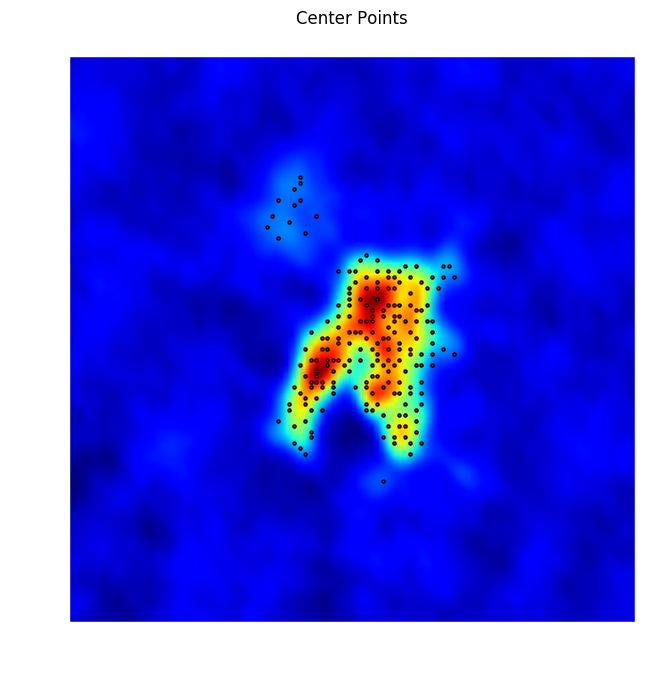

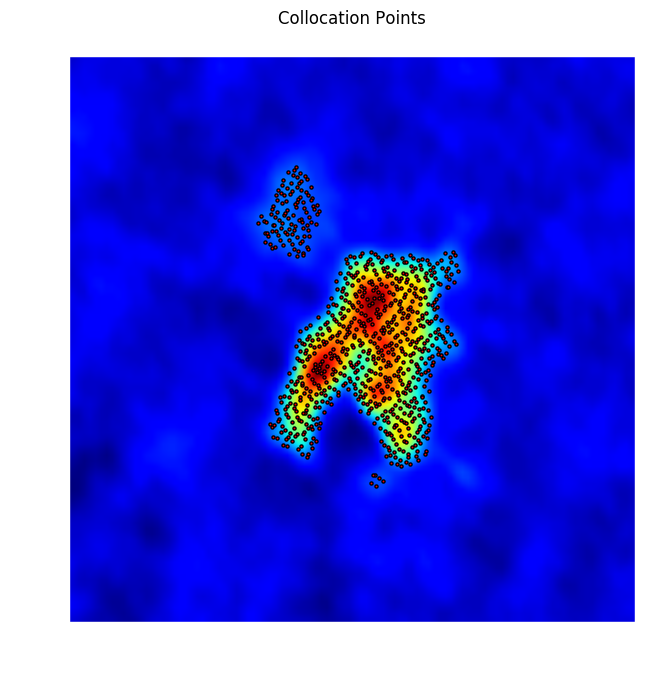

In [9]:
# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")

## Initial Conditions

In [10]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, method='min_dist')

## Visualizing the initial solution

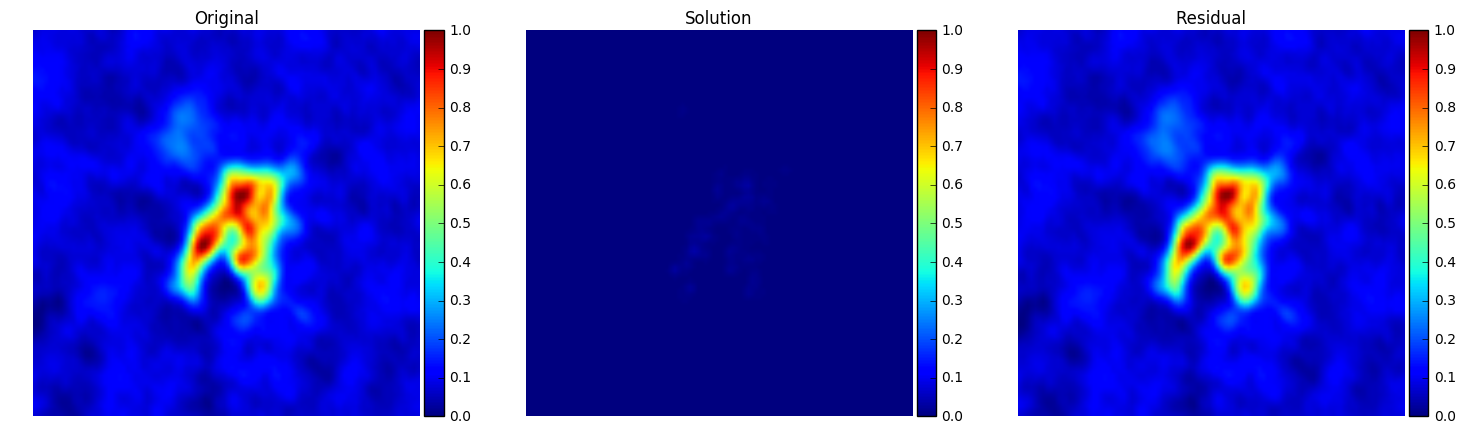

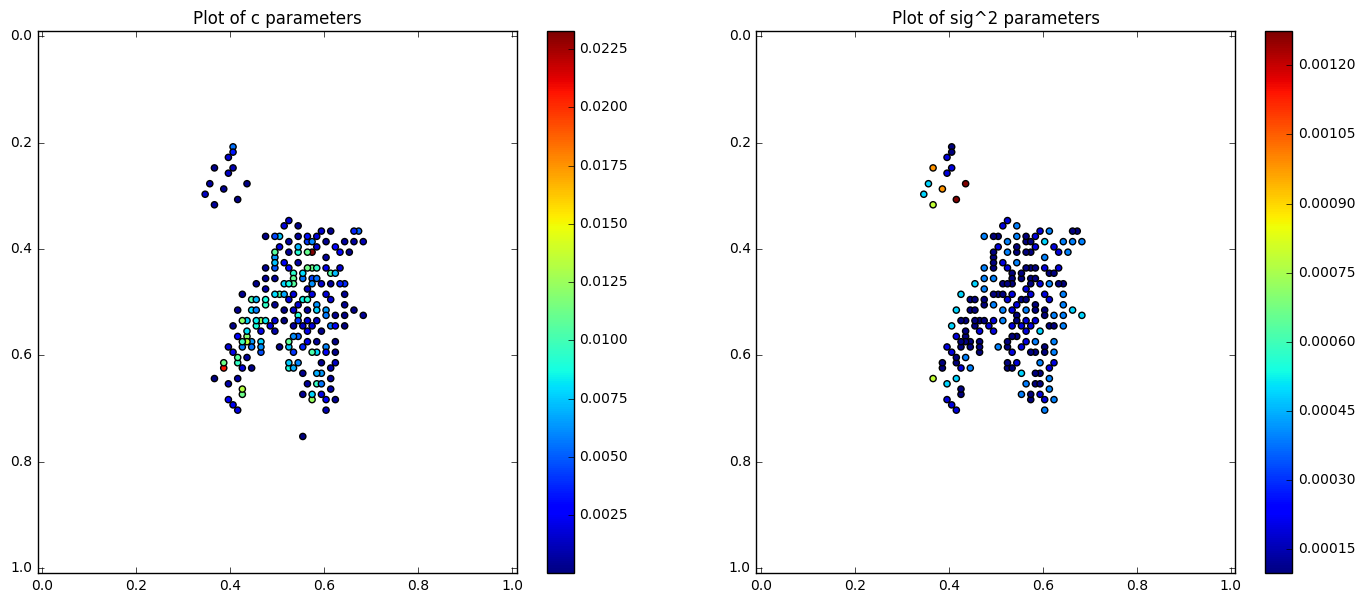

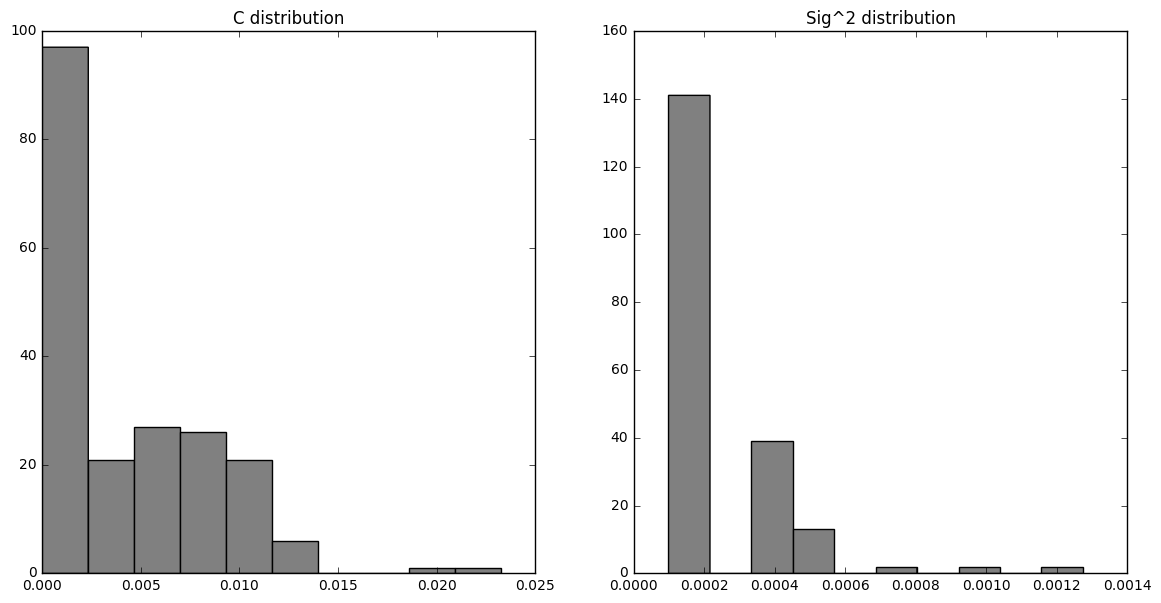

In [11]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=0., compact_supp=True)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

# Experiments: With  `base_level=RMS`
The following instances are tests with different settings combinations for: square_c

In [15]:
elf01 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on xc = 0.297211149597
Variation on yc = 0.209738356127
Variation on c = 0.889505955882
variation on sig = 0.11484698384

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on xc = 0.21063186675
Variation on yc = 0.25572331707
Variation on c = 0.455917094987
variation on sig = 0.138960664373

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

##########################################################################################
Results after 6000 iterations
#######

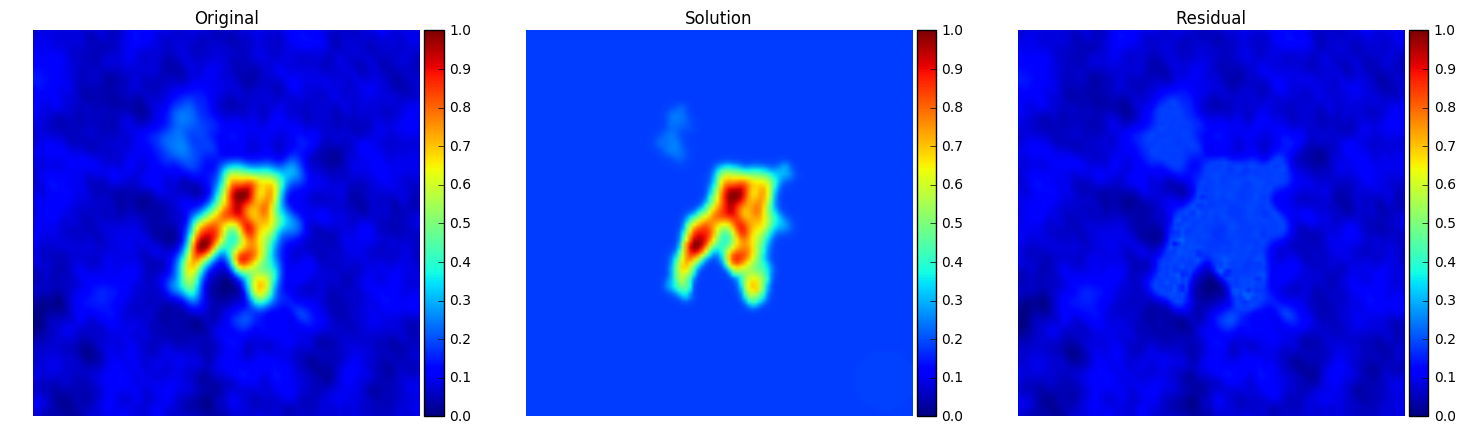

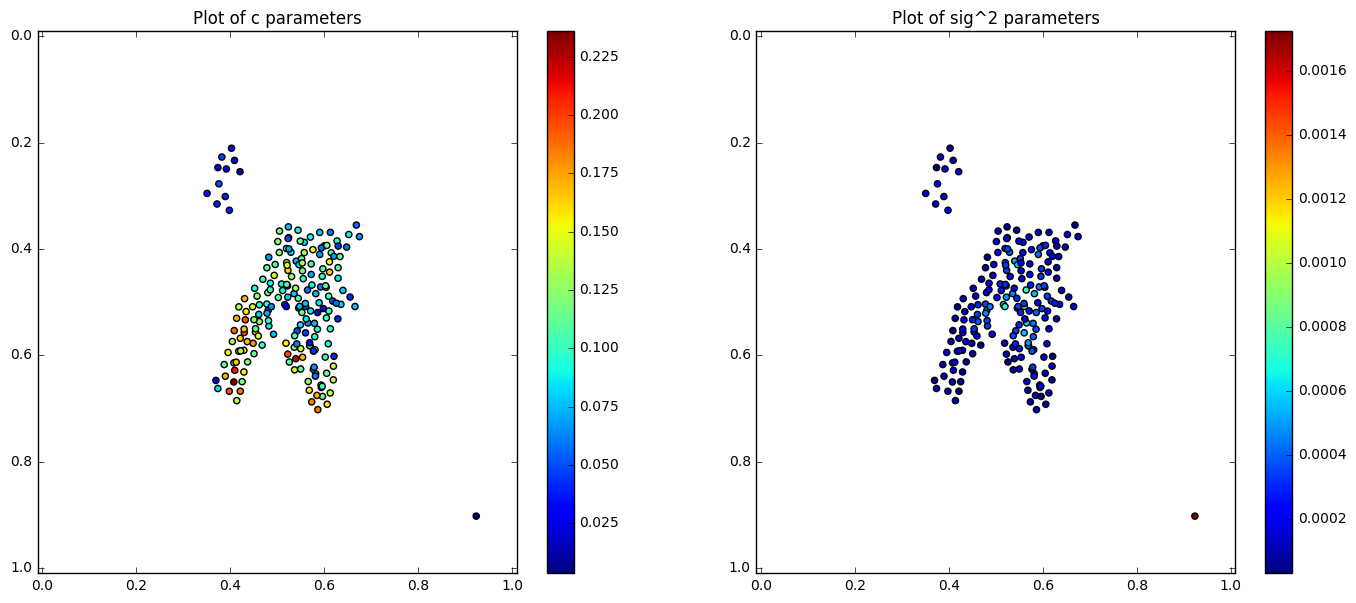

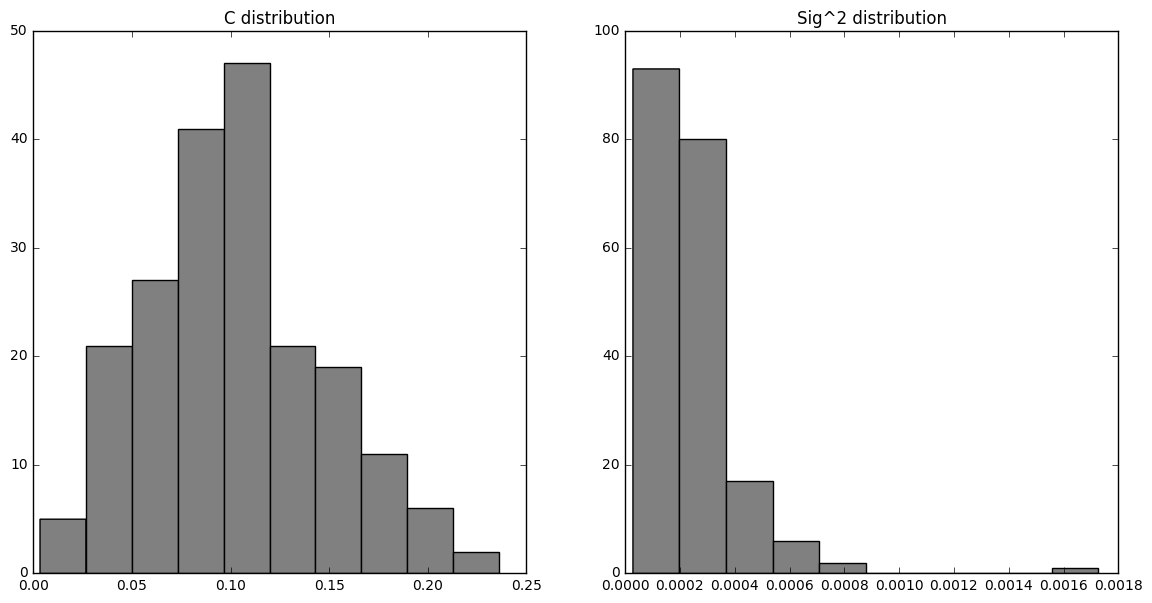

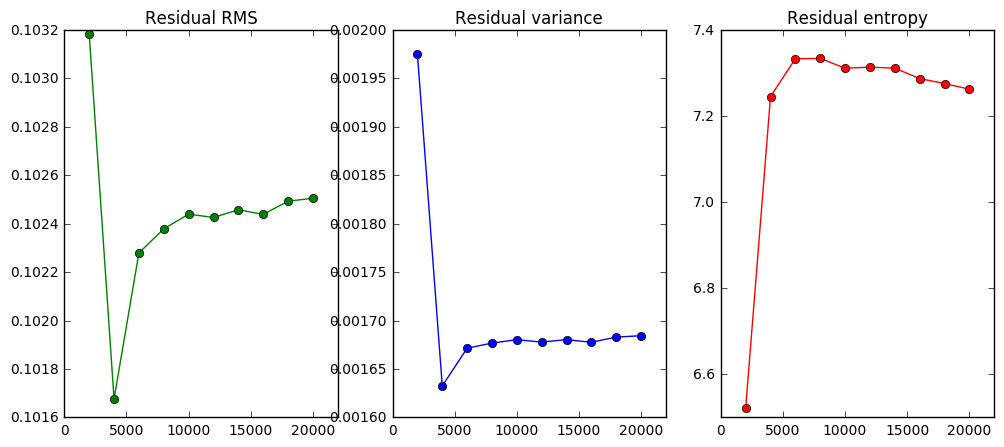

In [16]:
el_solver(elf01, method='exact', step_iter=2000, max_iter=20000)

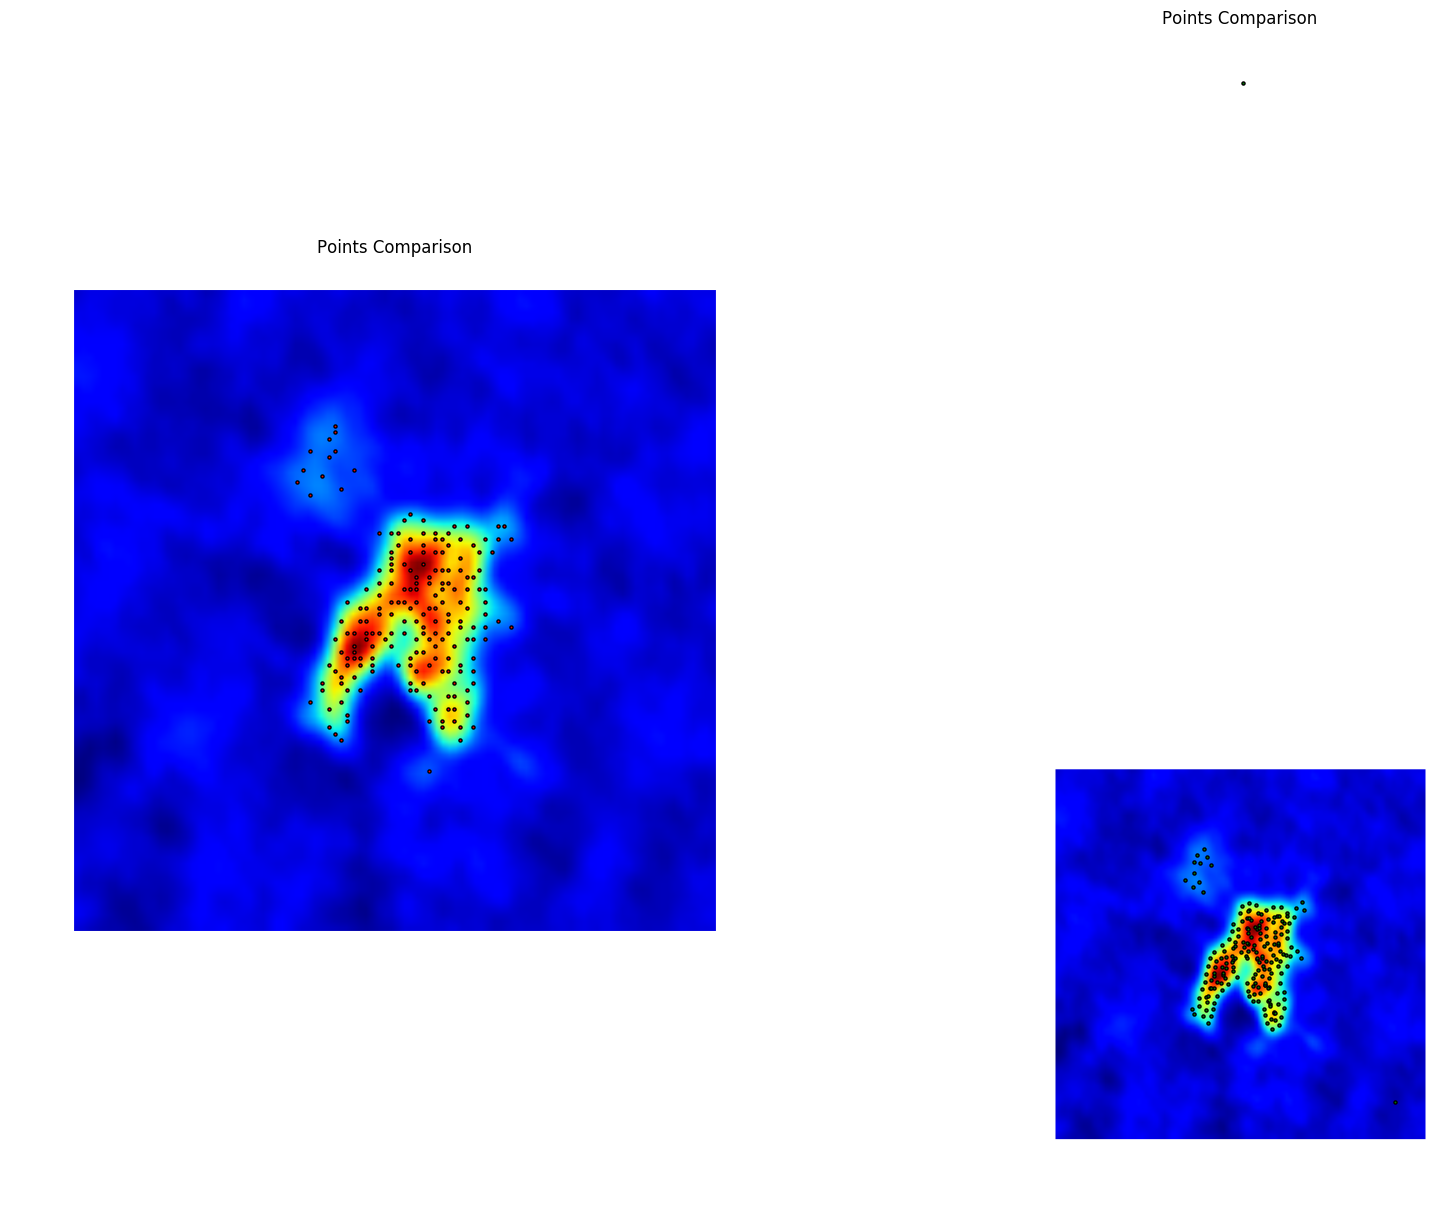

In [17]:
# visualizing the choosen points
fcenter_points = np.vstack((elf01.xc, elf01.yc)).T
points_plot(data, center_points=center_points, collocation_points=fcenter_points, title="Points Comparison")

****************************
****************************

# Agglomeration of Gaussians Step 

## Gaussian reduction through `KL-divergence`
### _A Kullback-Leibler Approach to Gaussian Mixture Reduction_

In [15]:
@numba.jit('float64[:,:] (float64[:], float64[:])')
def _outer(x, y):
    m = x.shape[0]
    n = y.shape[0]
    res = np.empty((m, n), dtype=np.float64)
    for i in range(m):
        for j in range(n):
            res[i, j] = x[i]*y[j]
    return res

@numba.jit('float64 (float64[:,:])')
def _det2D(X):
    return X[0,0]*X[1,1] - X[0,1]*X[1,0]

In [16]:
@numba.jit('Tuple((float64, float64[:], float64[:,:])) (float64, float64[:], float64[:,:], float64, float64[:], float64[:,:])', nopython=True)
def merge(c1, mu1, sig1, c2, mu2, sig2):
    c_m = c1+c2
    mu_m = (c1/c_m)*mu1 + (c2/c_m)*mu2
    sig_m = (c1/c_m)*sig1 + (c2/c_m)*sig2 + (c1/c_m)*(c2/c_m)*_outer(mu1-mu2, mu1-mu2)
    return (c_m, mu_m, sig_m) 

@numba.jit('float64 (float64, float64[:], float64[:,:], float64, float64[:], float64[:,:])', nopython=True)
def KL_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    # merged moment preserving gaussian
    c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
    # KL divergence upper bound as proposed in: A Kullback-Leibler Approach to Gaussian Mixture Reduction
    return 0.5*((c1+c2)*np.log(_det2D(sig_m)) - c1*np.log(_det2D(sig1)) - c2*np.log(_det2D(sig2)))

In [17]:
# def merge(c1, mu1, sig1, c2, mu2, sig2):
#     c_m = c1+c2
#     mu_m = (c1/c_m)*mu1 + (c2/c_m)*mu2
#     sig_m = (c1/c_m)*sig1 + (c2/c_m)*sig2 + (c1/c_m)*(c2/c_m)*np.outer(mu1-mu2, mu1-mu2)
#     return (c_m, mu_m, sig_m)

# def KL_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
#     # merged moment preserving gaussian
#     c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
#     # KL divergence upper bound as proposed in: A Kullback-Leibler Approach to Gaussian Mixture Reduction
#     return 0.5*((c1+c2)*np.log(np.linalg.det(sig_m)) - c1*np.log(np.linalg.det(sig1)) - c2*np.log(np.linalg.det(sig2)))

In [18]:
def gaussian_reduction(c, mu, sig, n_comp, metric=KL_dissimilarity):
    c = c.tolist(); mu = map(np.array, mu.tolist()); sig = [(s**2)*np.identity(2) for s in sig]
    # indexes of the actual gaussian components
    components = [[i] for i in range(len(c))]
    components_dict = {len(components) : copy.deepcopy(components)}
    # main loop
    while len(components)>n_comp:
        m = len(c)
        diss_min = np.inf
        i_min = -1; j_min = -1
        for i in range(m):
            for j in range(i+1,m):
                diss = metric(c[i], mu[i], sig[i], c[j], mu[j], sig[j])
                if diss < diss_min: i_min = i; j_min = j; diss_min = diss
        # compute the moment preserving  merged gaussian
        c_m, mu_m, sig_m = merge(c[i_min], mu[i_min], sig[i_min], c[j_min], mu[j_min], sig[j_min])
        # updating structures
        print('Merged components {0} and {1} with {2} dissimilarity'.format(i_min, j_min, diss_min))
        del c[max(i_min, j_min)]; del c[min(i_min, j_min)]; c.append(c_m)
        del mu[max(i_min, j_min)]; del mu[min(i_min, j_min)]; mu.append(mu_m)
        del sig[max(i_min, j_min)]; del sig[min(i_min, j_min)]; sig.append(sig_m)
        new_component = components.pop(max(i_min,j_min)) + components.pop(min(i_min,j_min))
        new_component.sort()
        components.append(new_component)
        components_dict[m-1] = copy.deepcopy(components)
    return components_dict

In [21]:
# extracting parameters
if elf01.square_c: c = elf01.c**2
else: c = elf01.c
    
mu = np.vstack([elf01.xc, elf01.yc]).T
sig = elf01.sig

In [22]:
components_dict01 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 36 and 152 with 7.42657004927e-05 dissimilarity
Merged components 26 and 42 with 9.49443192144e-05 dissimilarity
Merged components 18 and 88 with 0.000137840120093 dissimilarity
Merged components 64 and 145 with 0.00017075903774 dissimilarity
Merged components 3 and 111 with 0.000328733607422 dissimilarity
Merged components 68 and 95 with 0.000539607660476 dissimilarity
Merged components 13 and 156 with 0.000584541960031 dissimilarity
Merged components 108 and 119 with 0.000752624800605 dissimilarity
Merged components 30 and 67 with 0.000841016667542 dissimilarity
Merged components 42 and 151 with 0.000973011548861 dissimilarity
Merged components 42 and 97 with 0.0010055026405 dissimilarity
Merged components 7 and 32 with 0.00119518858857 dissimilarity
Merged components 43 and 48 with 0.00132467466015 dissimilarity
Merged components 86 and 136 with 0.00147898850354 dissimilarity
Merged components 18 and 33 with 0.00155570213429 dissimilarity
Merged components 35 and 4

In [23]:
def components_plot(elf, data, components_dict, n_comp, dims, resolution=1, n_levels=5):
    xc = elf.xc; yc = elf.yc; c = elf.c; sig = elf.sig
    _xe = np.linspace(0., 1., resolution*dims[0])[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1])[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if elf.square_c: c = c**2
    if elf.compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)    
    
    plt.figure(figsize=(10,10))
    plt.title('{0} components solution'.format(n_comp))
    plt.axis('off')
    ax = plt.subplot(1,1,1)
    ax.imshow(data, cmap=plt.cm.gray)
    color = plt.cm.rainbow(np.linspace(0.,1.,n_comp))
    levels = np.linspace(1.05*base_level, 0.95, n_levels)
    
    
    for i,indexes in enumerate(components_dict[n_comp]):
        _phi_m = phi_m.T[indexes].T
        _c = c[indexes]
        _u = np.dot(_phi_m, _c) + elf.base_level
        _u = _u.reshape(len_xe, len_ye)
        
        ax.contour(_u, levels=levels, colors=[color[i]])
        #plt.subplot(n_comp,1, i+1)
        #ax = plt.gca()
        #im = ax.imshow(_u, vmin=0., vmax=1.)
        #plt.axis('off')
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #plt.colorbar(im, cax=cax)
    plt.show()
    
def components_plot2(elf, components_dict, n_comp, dims, resolution=2):
    xc = elf.xc; yc = elf.yc; c = elf.c; sig = elf.sig
    _xe = np.linspace(0., 1., resolution*dims[0])[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1])[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if elf.square_c: c = c**2
    if elf.compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)    
    
    plt.figure(figsize=(12,12))
    plt.title('{0} components solution'.format(n_comp))
    j = 1
    
    for i,indexes in enumerate(components_dict[n_comp]):
        _phi_m = phi_m.T[indexes].T
        _c = c[indexes]
        _u = np.dot(_phi_m, _c) + elf.base_level
        _u = _u.reshape(len_xe, len_ye)
        
        __u = _u[_u > base_level]
        
        plt.subplot(n_comp,1, j)
        j+=1
        
        ax = plt.gca()
        __u = np.log10(_u)
        im = ax.imshow(_u, vmin=0., vmax=1.)
        #im = ax.imshow((__u + __u.min())/(__u.max()-__u.min()), vmin=0., vmax=1.)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        #plt.subplot(2*n_comp,1,j)
        #plt.hist(_u.ravel(), bins=400, log=True)
        #j+=1
    plt.show()

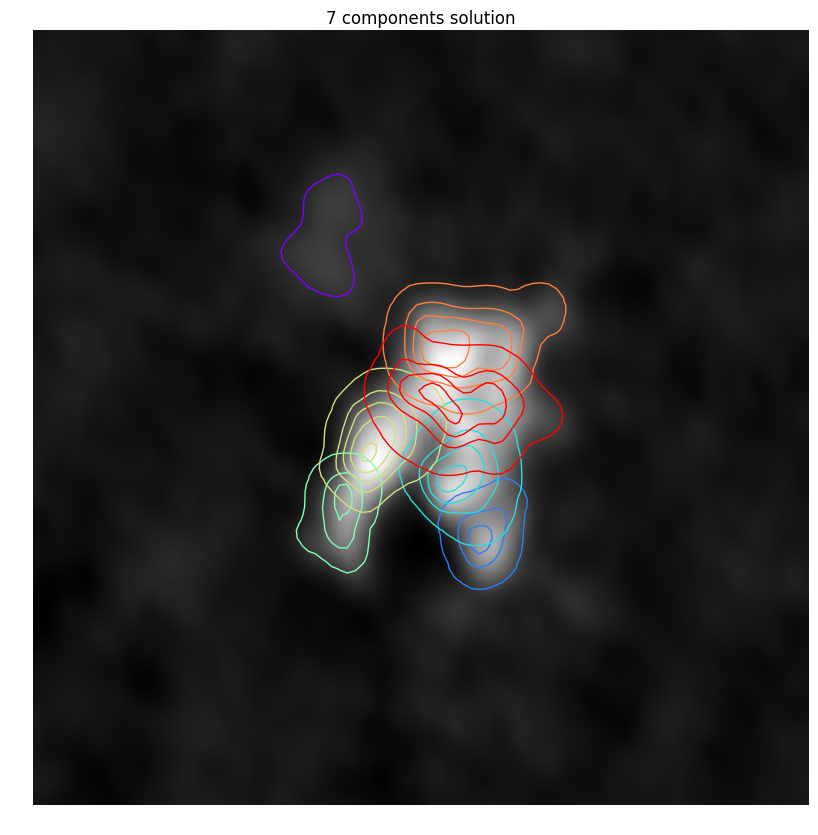

In [26]:
interact(components_plot, elf=fixed(elf01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

## Gaussian reduction through `ISD` (_Integrated Square Difference_)
### _Cost-Function-Based Gaussian Mixture Reduction for Target Tracking_

In [52]:
def ISD_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    # merged moment preserving gaussian
    c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
    # ISD analytical computation between merged component and the pair of gaussians
    Jhr = c1*c_m * np.exp( -0.5 * np.dot((mu1-mu_m), np.dot(np.linalg.inv(sig1+sig_m), mu1-mu_m)) ) + c2*c_m * np.exp( -0.5 * np.dot((mu2-mu_m), np.dot(np.linalg.inv(sig2+sig_m), mu2-mu_m)) )
    Jrr = c_m**2
    Jhh = c1**2 + c2**2 + 2*c1*c2* np.exp( -0.5 * np.dot((mu1-mu2), np.dot(np.linalg.inv(sig1+sig2), mu1-mu2)) )
    return Jhh - 2*Jhr + Jrr

In [53]:
comp2 = gaussian_reduction(c, mu, sig, n_comp=5, metric=ISD_dissimilarity)

Merged components 52 and 70 with -0.000518399365307 dissimilarity


KeyboardInterrupt: 